In [1]:
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(color_codes=True)
seed = 423
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

In [4]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

In [5]:
def linear(input, output_dim, scope=None, stddev=1.0):
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable(
            'w',
            [input.get_shape()[1], output_dim],
            initializer=tf.random_normal_initializer(stddev=stddev)
        )
        b = tf.get_variable(
            'b',
            [output_dim],
            initializer=tf.constant_initializer(0.0)
        )
        return tf.matmul(input, w) + b

In [6]:
def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

In [8]:
def discriminator(input, hidden_size):
    h0 = tf.tanh(linear(input, hidden_size * 2, 'd0'))
    h1 = tf.tanh(linear(h0, hidden_size * 2, 'd1'))
    h2 = tf.tanh(linear(h1, hidden_size * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

In [9]:
def optimizer2(loss, var_list):
    learning_rate = 0.001
    step = tf.Variable(0, trainable=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
        loss,
        global_step=step,
        var_list=var_list
    )
    return optimizer

In [10]:
def optimizer(loss, var_list):
    initial_learning_rate = 0.005
    decay = 0.99
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer =  tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

In [11]:
def log(x):
    '''
    Sometimes discriminiator outputs can reach values close to
    (or even slightly less than) zero due to numerical rounding.
    This just makes sure that we exclude those values so that we don't
    end up with NaNs during optimisation.
    '''
    return tf.log(tf.maximum(x, 1e-5))

In [12]:
class GAN(object):
    def __init__(self, params):
        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('G'):
            self.z = tf.placeholder(tf.float32, shape=(params.batch_size, 1))
            self.G = generator(self.z, params.hidden_size)

        # The discriminator tries to tell the difference between samples from
        # the true data distribution (self.x) and the generated samples
        # (self.z).
        #
        # Here we create two copies of the discriminator network
        # that share parameters, as you cannot use the same network with
        # different inputs in TensorFlow.
        self.x = tf.placeholder(tf.float32, shape=(params.batch_size, 1))
        with tf.variable_scope('D'):
            self.D1 = discriminator(
                self.x,
                params.hidden_size
            )
        with tf.variable_scope('D', reuse=True):
            self.D2 = discriminator(
                self.G,
                params.hidden_size
            )

        # Define the loss for discriminator and generator networks
        # (see the original paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-log(self.D1) - log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-log(self.D2))

        vars = tf.trainable_variables()
        self.d_params = [v for v in vars if v.name.startswith('D/')]
        self.g_params = [v for v in vars if v.name.startswith('G/')]

        self.opt_d = optimizer(self.loss_d, self.d_params)
        self.opt_g = optimizer(self.loss_g, self.g_params)

In [13]:
def train(model, data, gen, params):
    with tf.Session() as session:
        tf.local_variables_initializer().run()
        tf.global_variables_initializer().run()

        for step in range(params.num_steps + 1):
            # update discriminator
            x = data.sample(params.batch_size)
            z = gen.sample(params.batch_size)
            loss_d, _, = session.run([model.loss_d, model.opt_d], {
                model.x: np.reshape(x, (params.batch_size, 1)),
                model.z: np.reshape(z, (params.batch_size, 1))
            })

            # update generator
            z = gen.sample(params.batch_size)
            loss_g, _ = session.run([model.loss_g, model.opt_g], {
                model.z: np.reshape(z, (params.batch_size, 1))
            })

            if step % params.log_every == 0:
                print('{}: {:.4f}\t{:.4f}'.format(step, loss_d, loss_g))
                samps = samples(model, session, data, gen.range, params.batch_size)
                plot_distributions(samps, gen.range)


In [14]:
def samples(
    model,
    session,
    data,
    sample_range,
    batch_size,
    num_points=10000,
    num_bins=100
):
    '''
    Return a tuple (db, pd, pg), where db is the current decision
    boundary, pd is a histogram of samples from the data distribution,
    and pg is a histogram of generated samples.
    '''
    xs = np.linspace(-sample_range, sample_range, num_points)
    bins = np.linspace(-sample_range, sample_range, num_bins)

    # decision boundary
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        db[batch_size * i:batch_size * (i + 1)] = session.run(
            model.D1,
            {
                model.x: np.reshape(
                    xs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
                )
            }
        )

    # data distribution
    d = data.sample(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)

    # generated samples
    zs = np.linspace(-sample_range, sample_range, num_points)
    g = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        g[batch_size * i:batch_size * (i + 1)] = session.run(
            model.G,
            {
                model.z: np.reshape(
                    zs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
                )
            }
        )
    pg, _ = np.histogram(g, bins=bins, density=True)

    return db, pd, pg

In [15]:
def plot_distributions(samps, sample_range):
    db, pd, pg = samps
    db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

In [16]:
class Args:
    hidden_size =10
    batch_size = 5
    num_steps = 10000
    log_every = 1000

In [17]:
args = Args()
model = GAN(args)

0: 3.9785	1.1853


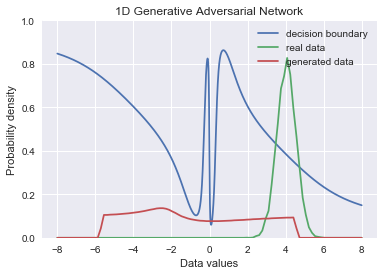

1000: 0.8504	3.2312


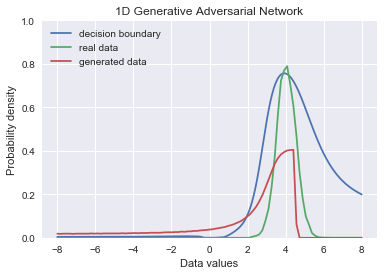

2000: 0.8422	3.5218


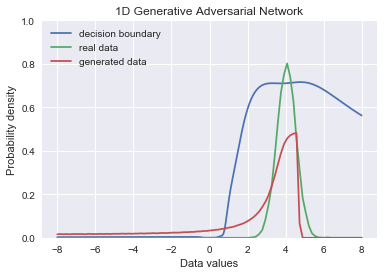

3000: 0.8456	3.7054


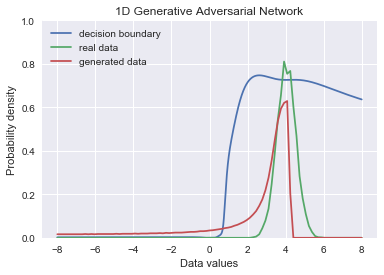

4000: 0.8428	3.8176


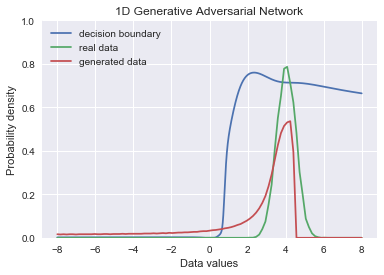

5000: 0.8318	3.8885


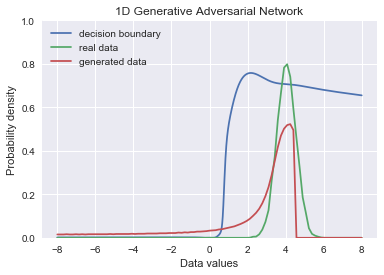

6000: 0.8351	3.9187


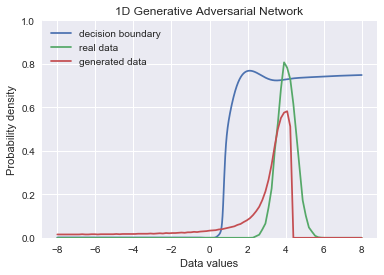

7000: 0.8396	3.9784


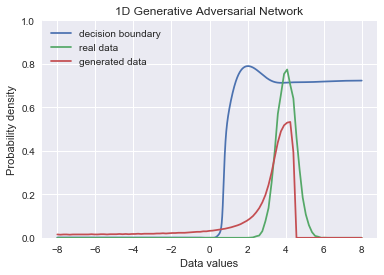

8000: 0.8446	4.0053


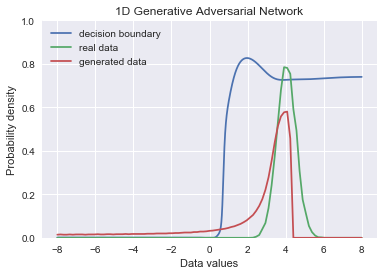

9000: 0.8410	4.0382


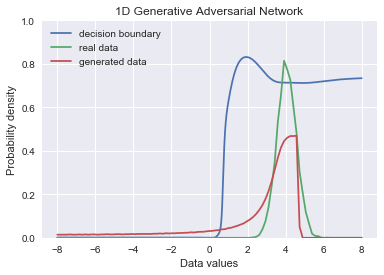

10000: 0.8415	4.0533


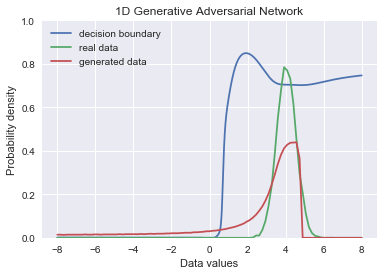

In [18]:
train(model, DataDistribution(), GeneratorDistribution(range=8), args)